In [123]:
# Standard data library imports, and initialise dataframe
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

df = pd.read_csv("./NVDA.csv")
# Use the data from 14 days ago to predict the current day's data
df['FutureClose'] = df.Close.shift(-28).shift(14)

# Swap columns such that volume is the last column
cols = list(df.columns)
a, b = cols.index('Volume'), cols.index('FutureClose')
cols[b], cols[a] = cols[a], cols[b]
df = df[cols]
df.set_index(pd.to_datetime(df['Date']))

,Date,Open,High,Low,Close,Adj Close,FutureClose,Volume
Date,,,,,,,,
2003-10-01,2003-10-01,1.333333,1.357500,1.330000,1.341667,1.231633,NaN,87722400
2003-10-02,2003-10-02,1.333333,1.381667,1.329167,1.362500,1.250757,NaN,85762800
2003-10-03,2003-10-03,1.400000,1.433333,1.375833,1.398333,1.283652,NaN,86281200
2003-10-06,2003-10-06,1.400833,1.415000,1.375833,1.387500,1.273707,NaN,37702800
2003-10-07,2003-10-07,1.387500,1.400000,1.368333,1.400000,1.285182,NaN,51058800
...,...,...,...,...,...,...,...,...
2022-10-17,2022-10-17,115.180000,119.480003,115.169998,118.879997,118.879997,NaN,58077400
2022-10-18,2022-10-18,123.440002,124.919998,116.180000,119.669998,119.669998,NaN,65936200
2022-10-19,2022-10-19,118.790001,123.500000,118.339996,120.510002,120.510002,NaN,52313100


# Initial Data Cleaning

Since the end goal is to create a model that forecasts the closing price of a stock, i'm going to filter out the _volume_ of the stock.

The variables that we will consider for our multivariate LSTM are:
1. Opening price
2. Daily High
3. Daily Low
4. Closing Price
5. Adjusted Closing Price

In [124]:
# Get dates for plotting
dates = pd.to_datetime(df["Date"])

# Filter dataframe to required variables only
requisite_cols = list(df)[1:7]
trimmed_df = df[requisite_cols].astype(float)
trimmed_df.set_index(dates)

,Open,High,Low,Close,Adj Close,FutureClose
Date,,,,,,
2003-10-01,1.333333,1.357500,1.330000,1.341667,1.231633,NaN
2003-10-02,1.333333,1.381667,1.329167,1.362500,1.250757,NaN
2003-10-03,1.400000,1.433333,1.375833,1.398333,1.283652,NaN
2003-10-06,1.400833,1.415000,1.375833,1.387500,1.273707,NaN
2003-10-07,1.387500,1.400000,1.368333,1.400000,1.285182,NaN
...,...,...,...,...,...,...
2022-10-17,115.180000,119.480003,115.169998,118.879997,118.879997,NaN
2022-10-18,123.440002,124.919998,116.180000,119.669998,119.669998,NaN
2022-10-19,118.790001,123.500000,118.339996,120.510002,120.510002,NaN


## Scaling of the data

In order to ensure that the model will not be too sensitive to magnitude of values, let's scale the values in the dataset to have mean 0 and unit variance using SKLearn's StandardScaler.

In [192]:
scaler = StandardScaler()
scaler = scaler.fit(trimmed_df)
trimmed_scaled_df = scaler.transform(trimmed_df)
trimmed_scaled_df

<class 'numpy.ndarray'>


## Reshaping the data

Now, let's reshape the data into usable samples that the model can use to train. The way that we are going to do this is via a sliding window, where we will consider the past 2 weeks of data (14 days) to predict the outcome for the next day, and move the window 1 day at a time.


In [126]:
X_train = [] # our training data
Y_train = [] # our prediction data to validate against
X_val = []
Y_val = []

training_data_length = int(np.ceil((len(trimmed_scaled_df)) * 0.90))
print(len(trimmed_scaled_df), training_data_length)
val_data_length = len(trimmed_scaled_df) - training_data_length - 14
print(val_data_length)


4799 4320
465


In [127]:
n_future = 1 # look 1 day into the future
n_past = 14 # use the past 2 weeks of data

# starting at n_past (we need n_past many values), add n_past past values to train
# then add the current index of i + n_future for prediction
for i in range(n_past, training_data_length - n_future + 1):
    X_train.append(trimmed_scaled_df[i - n_past: i, 0:trimmed_scaled_df.shape[1] - 1])
    Y_train.append(trimmed_scaled_df[i + n_future - 1: i + n_future, 5])

for i in range(training_data_length, training_data_length + val_data_length - n_future + 1):
    X_val.append(trimmed_scaled_df[i - n_past: i, 0:trimmed_scaled_df.shape[1] - 1])
    Y_val.append(trimmed_scaled_df[i + n_future - 1: i + n_future, 5])

X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_val = np.array(X_val)
Y_val = np.array(Y_val)

print(X_val, Y_val)



[[[1.77225474 1.80438542 1.78878911 1.8488971  1.84824225]
  [1.845622   1.82107228 1.74058729 1.69444823 1.69414228]
  [1.68886192 1.64486499 1.57397944 1.5516919  1.55170811]
  ...
  [1.61673718 1.6084866  1.63964751 1.61305677 1.61293493]
  [1.61197321 1.57267667 1.61751803 1.58283048 1.58277629]
  [1.59374518 1.5901352  1.64041056 1.62877133 1.62861316]]

 [[1.845622   1.82107228 1.74058729 1.69444823 1.69414228]
  [1.68886192 1.64486499 1.57397944 1.5516919  1.55170811]
  [1.59726664 1.61701291 1.62824354 1.65916337 1.65893724]
  ...
  [1.61197321 1.57267667 1.61751803 1.58283048 1.58277629]
  [1.59374518 1.5901352  1.64041056 1.62877133 1.62861316]
  [1.65050038 1.61254668 1.66593176 1.63316637 1.63299854]]

 [[1.68886192 1.64486499 1.57397944 1.5516919  1.55170811]
  [1.59726664 1.61701291 1.62824354 1.65916337 1.65893724]
  [1.66773395 1.67076833 1.69060502 1.6655903  1.66534938]
  ...
  [1.59374518 1.5901352  1.64041056 1.62877133 1.62861316]
  [1.65050038 1.61254668 1.6659317

### What happens now?

As you can see, the data has now been re-shaped into a form that works best for the model: `X_train` consists of arrays of size 14, consisting of all variables we are going to use for prediction, while `Y_train` consists the prediction result that we are going to train against.

In [160]:
model = Sequential()
model.add(LSTM(64, activation = "relu", input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences = True))
model.add(LSTM(32, activation = "relu", return_sequences = True))
# Note that we are using a stacked LSTM with 64 units and then 32 units respectively.
model.add(LSTM(32, activation = "relu", return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(Y_train.shape[1]))

model.compile(optimizer = "adam", loss = "mse")
model.summary()

history = model.fit(X_train, Y_train, epochs = 4, batch_size = 32, validation_split = 0.1, verbose = 1)
# 4, 32 is pretty good.

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_116 (LSTM)             (None, 14, 64)            17920     
                                                                 
 lstm_117 (LSTM)             (None, 14, 32)            12416     
                                                                 
 lstm_118 (LSTM)             (None, 32)                8320      
                                                                 
 dropout_39 (Dropout)        (None, 32)                0         
                                                                 
 dense_39 (Dense)            (None, 1)                 33        
                                                                 
Total params: 38,689
Trainable params: 38,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
122/122 [==============================

# Training and Validation Losses

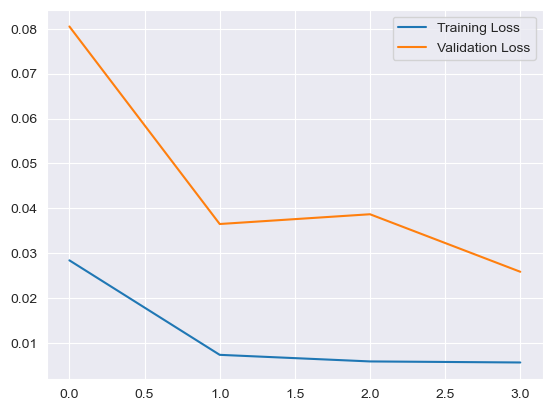

In [161]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()

|# Actual Forecasting

Let's predict the stock price for 2 weeks in the future of this dataset.
Note that we cannot predict into the future since we're only predicting a single variable: Closing price, but we need all 5 new variable values in order to make a continuous prediction into the future.

465
15/15 - 0s - 331ms/epoch - 22ms/step
[[1.6212564]
 [1.6085176]
 [1.599596 ]
 [1.6013407]
 [1.6017888]
 [1.6009797]
 [1.6020458]
 [1.6041001]
 [1.6051779]
 [1.6048694]
 [1.6031885]
 [1.6006743]
 [1.5998656]
 [1.6014417]
 [1.6024128]
 [1.601349 ]
 [1.6005012]
 [1.5985689]
 [1.596185 ]
 [1.5928814]
 [1.588227 ]
 [1.5821295]
 [1.5772018]
 [1.5758086]
 [1.5763605]
 [1.5772029]
 [1.5757776]
 [1.572377 ]
 [1.570164 ]
 [1.5689547]
 [1.5708637]
 [1.5743986]
 [1.5783217]
 [1.5834632]
 [1.5875635]
 [1.5904841]
 [1.5928099]
 [1.5959727]
 [1.6021197]
 [1.6063952]
 [1.6102366]
 [1.6149154]
 [1.6154945]
 [1.6135836]
 [1.6072892]
 [1.6039522]
 [1.6039287]
 [1.6056359]
 [1.611882 ]
 [1.6207615]
 [1.630158 ]
 [1.6390233]
 [1.6515024]
 [1.668786 ]
 [1.6899441]
 [1.7166023]
 [1.7399966]
 [1.7636037]
 [1.7831299]
 [1.7941532]
 [1.8014375]
 [1.8050649]
 [1.8046303]
 [1.7984189]
 [1.7883506]
 [1.7720802]
 [1.747381 ]
 [1.7178557]
 [1.6810968]
 [1.6464177]
 [1.6161654]
 [1.5877246]
 [1.5652623]
 [1.552322

/Users/IanChng/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/IanChng/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='Close'>

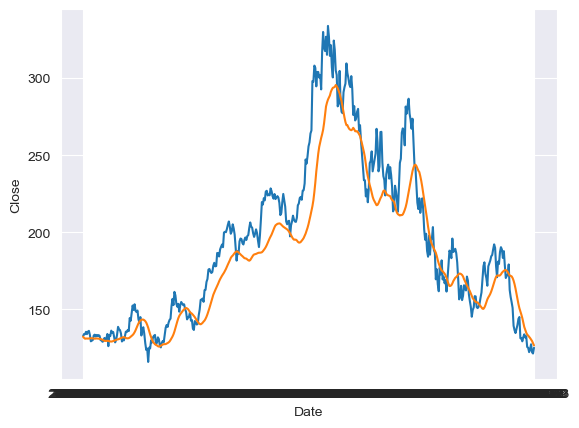

In [162]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Standard boilerplate for setting date offsets to only US business days
us_business_days = CustomBusinessDay(calendar = USFederalHolidayCalendar())

# # Remember that we can only predict one day in future as our model needs 5 variables
# # as inputs for prediction. We only have all 5 variables until the last day in our dataset.
# n_past = 91
# n_days_for_prediction=90  # Let us predict for 15 continuous days (that happened in the past)
#
# # Generating the actual period dates for prediction
# predict_period_dates = pd.date_range(list(dates)[-n_past], periods = n_days_for_prediction, freq = us_business_days).tolist()
# print(predict_period_dates)
#
# # Actually make the prediction
# # Note that the model takes in a series of data related to 5 variables that are of a specified length, and spits out a prediction afterwards
# prediction = model.predict(X_train[-n_days_for_prediction:], verbose = 2)
# print(prediction)

print(len(X_val))
prediction = model.predict(X_val, verbose = 2)
print(prediction)

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
'''
Note that earlier, we used the scaler to fit our dataframe that had 5 variables. In order to perform inverse_transform
to get our original value back, we need to get a dataframe that has the same number of variables as well, which, in this case, is 5.
np.repeat does this for us easily.
'''
prediction_copies = np.repeat(prediction, trimmed_scaled_df.shape[1], axis = 1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,5]
df_new = pd.DataFrame(df[['Date', 'Close']]).loc[training_data_length: training_data_length + val_data_length - 1]
df_new['Pred'] = y_pred_future
df_new.set_index('Date')


sns.lineplot(df_new['Date'], df_new['Close'])
sns.lineplot(df_new['Date'], df_new['Pred'])
# At this point, y_pred_future contains the predicted values of our closing price.

# Graphing results

Now that we have our predicted (past) values of our closing price, all we need to do is graph them to see how they vary as compared to true historical data.

In [209]:
# True predictions: Take data from 14 days before the forecast, convert to valid input, then predict
df_predict = pd.DataFrame(trimmed_scaled_df).iloc[-37:-4]
df_predict_series = df_predict.to_numpy()

X_predict = []
for i in range(0, 10):
    X_predict.append(df_predict_series[i: i + 14, 0:df_predict_series.shape[1] - 1])
X_predict = np.array(X_predict)
prediction = model.predict(X_predict, verbose = 2)
prediction_copies = np.repeat(prediction, trimmed_scaled_df.shape[1], axis = 1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,5]
print(y_pred_future)
result_df = pd.DataFrame({'Close': y_pred_future})
result_df.index.name = 'Index'
result_df.to_csv("./MultivariateLSTMPredict")

1/1 - 0s - 22ms/epoch - 22ms/step
[134.9611  133.66365 133.01761 132.2236  131.41544 130.51291 129.49965
 128.088   126.63432 125.80425]
